In [2]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
import yt
import matplotlib.cm as cm
from plot_variables import *
from yt.utilities.math_utils import ortho_find


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from helper_functions import *

In [4]:
data_files = ['data_files/data-1B.RSb01-2.csv', 
              #'data_files/data-2B.RSb01.csv',
              'data_files/data-1B.resim.th.b01.csv']

label = extract_simulation_name_from_csv(data_files[1])

In [5]:
label

'1B.resim.th.b01'

In [6]:
def setup_plot_env(fontsize, linewidth):
    rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
    rc('text', usetex=True)
    plt.rcParams["mathtext.default"] = "regular"
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['lines.linewidth'] = linewidth


# Function to format and create the subplots
def create_subplots(num_subplots, xlim, ylim_mass, time_cutoff, fontsize, title):
    fig, axs = plt.subplots(num_subplots, 1, sharex=True)

    for i in range(num_subplots):
        axs[i].set_xticks(np.arange(0.1, time_cutoff+0.1, 0.1))
        axs[i].minorticks_on()
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i].tick_params(axis="x", which='major', labelsize=fontsize-1, width=1.5, length=3, direction="in")
        axs[i].tick_params(axis="y", which='major', labelsize=fontsize-1)
        axs[i].tick_params(axis="y", which='minor', labelsize=fontsize-2)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0, xlim+0.01]) # for truncated view

    axs[0].set_title(title)
    #axs[0].set_ylim([10.5, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
    axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
    axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
    #axs[1].set_ylim([2e-9, 8e-4]) # [2e-9, 8e-4] for 270msun, [5e-9, 6e-2] for 10.8msun-no-SN, [2e-9, 8e-4] for 10.8msun
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

    return fig, axs


In [7]:
def dynamical_timescale_ff(rho):
    # rho in g/cm^3
    return np.sqrt(3*np.pi/(32*6.67e-8*rho))

def dynamical_timescale_vel(v_orb, r):
    # v in cm/s, r in cm
    return 2*np.pi*r/v_orb

$\rho$ = 2e+05


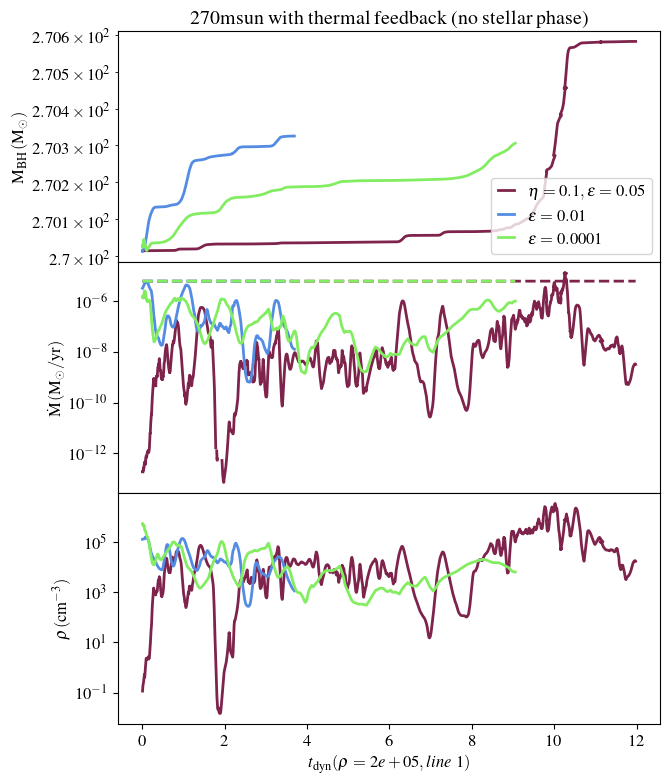

In [22]:
# Set up plot environment
fontsize = 12
linewidth = 2
alpha = 1
setup_plot_env(fontsize, linewidth)
num_subplots = 3
#title = '270msun resimulated from 31.7 Myr with thermal feedback'
title = '270msun with thermal feedback (no stellar phase)'
fig, axs = plt.subplots(num_subplots, 1, sharex=True)


# Load the CSV file into a DataFrame
data_files = [#'data_files/data-1B.RSb04.csv', 
              #'data_files/data-2B.RSb01.csv',
              #'data_files/data-1B.resim.th.b01.csv'
    # 'data_files/data-1B.RSb01-2.csv',
    # 'data_files/data-1B.resim.th.b01-3-eta-0.1.csv',
    # 'data_files/data-1B.resim.th.b01-3-eta-0.01.csv',
    # 'data_files/data-1B.resim.th.b01-3-eps-0.001.csv',
    # 'data_files/data-1B.resim.th.b01-3-eps-0.0001.csv'
    'data_files/data-1B.th.bf128.csv',
    'data_files/data-1B.th.bf128-eps-0.01.csv',
    'data_files/data-1B.th.bf128-eps-0.0001.csv',
    ]

# Line colours
c = extract_colors('arbre', int(len(data_files)), start=0.1, end=0.86) # start=0.33, end=0.92 for 10.8msun-no-sn
#c_s2 = extract_colors('magma', int(len(data_files)/2), portion="middle", start=0.4, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
#c = np.concatenate((c_s1, c_s2))

# Data labels
#labels = [extract_simulation_name_from_csv(data_file) for data_file in data_files]
#labels = ['no-fb', r"$\rm \eta=0.1$, $\epsilon=0.05$", r"$\times 0.1$", r"$\times 0.05$", r"$\times 0.005$"]
labels = [r"$\rm \eta=0.1, \epsilon=0.05$", r"$\epsilon=0.01$", r"$\epsilon=0.0001$"]

# Define rho for the dynamical timescale
rho_index = 1
df = pd.read_csv(data_files[rho_index])
rho = df['average density'].values.mean()
print(r"$\rho$ = {:.0e}".format(rho))

# find the dynamical timescale 
mh = 1.6735e-24 # hydrogen mass in g
t_ff = dynamical_timescale_ff(rho*mh)/3.15576e13
    
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    window_size = 100
    #age = df['age'].values/1e6
    age = (df['age'].values/1e6)/t_ff
    bh_mass = adaptive_moving_average(df['BH mass'].values, window_size)
    accrate = adaptive_moving_average(df['accrate'].values, window_size)
    density = adaptive_moving_average(df['average density'].values, window_size)
    #age = np.linspace(age[0], times[-1], len(accrate))

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)

    # 3) Density
    axs[2].plot(age, density, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)


# Set labels
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm \rho \, (cm^{-3})$", fontdict=None)
#axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)
axs[-1].set_xlabel(r'$t_{{\rm dyn}} (\rho = {:.0e}, line \ {})$'.format(rho, rho_index+1), fontdict=None)

# Set axes limits
#axs[0].set_ylim([60150, 60400]) # for truncated view 270msun: [240, ylim_mass+0.01]
#axs[-1].set_xlim([31.70, 31.75]) # for truncated view
#axs[1].set_ylim([2e-6, 2e-1]) # 

# legend and title
axs[0].legend(fontsize=fontsize, ncol=1, loc="lower right", handlelength=1) # "lower right" for no-sn
#axs[1].legend(accrate_line, [r"$\rm \dot{M}_{Edd}$"], loc="lower right", fontsize=fontsize-2.2, ncol=1)
fig.subplots_adjust(wspace=0, hspace=0)
axs[0].set_title(title)
fig.set_size_inches(7, 9)
#plt.show()

In [9]:
#plt.savefig('plots/mass_accrate_1B.resim.th.b01-3-x4.pdf', bbox_inches='tight')
#plt.savefig(f'no-feedback-pathfinders/mass_accrate_{labels[0]}_{labels[1]}_{time_cutoff}.pdf', bbox_inches='tight')
#print(f"Plot saved to no-feedback-pathfinders/mass_accrate_{labels[0]}_{labels[1]}_{time_cutoff}.pdf")

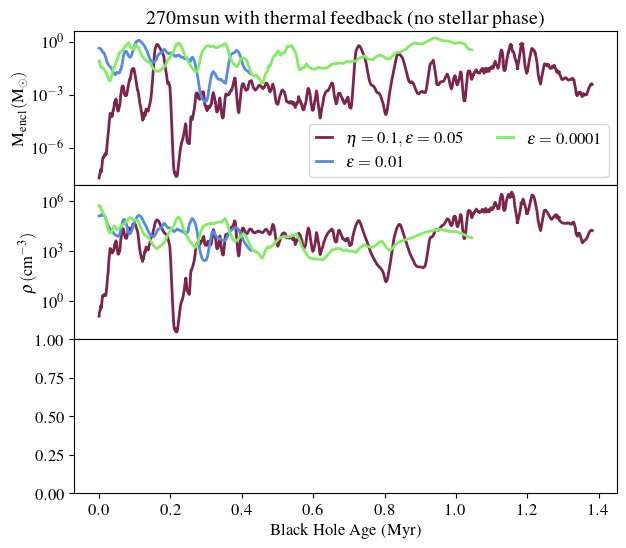

In [10]:
# Set axes limits 
time_cutoff = 2
ylim_mass = 6.1e4

# Set up plot environment
setup_plot_env(fontsize, linewidth)
fig, axs = plt.subplots(num_subplots, 1, sharex=True)

# Line colours
c = extract_colors('arbre', int(len(data_files)), start=0.1, end=0.86) # start=0.33, end=0.92 for 10.8msun-no-sn
#c_s2 = extract_colors('magma', int(len(data_files)/2), portion="middle", start=0.4, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
#c = np.concatenate((c_s1, c_s2))

#labels = [extract_simulation_name_from_csv(data_file) for data_file in data_files]
#labels = ['no-fb', r"$\rm \eta=0.1$, $\epsilon=0.05$", r"$\times 0.1$", r"$\times 0.05$", r"$\times 0.005$"]
for j, data_file in enumerate(data_files):
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    window_size = 100
    age = df['age'].values/1e6
    bh_mass = adaptive_moving_average(df['total gas mass'].values, window_size)
    accrate = adaptive_moving_average(df['average density'].values, window_size)
    #age = np.linspace(age[0], times[-1], len(accrate))

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    #axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)


# Set limits and labels
#axs[0].set_ylim([60150, 60400]) # for truncated view 270msun: [240, ylim_mass+0.01]
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel(r"$\rm \rho \, (cm^{-3})$", fontdict=None)
axs[0].set_ylabel(r"$\rm M_{encl} \, (M_{\odot})$", fontdict=None)
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)
#axs[-1].set_xlim([31.70, 31.75]) # for truncated view
#axs[0].set_ylim([0.02, 1.2]) # for truncated view
#axs[1].set_ylim([2e5, 2e7]) # for truncated view

# legend and title
axs[0].legend(fontsize=fontsize, ncol=2, loc="lower right", handlelength=1) # "lower right" for no-sn
#axs[1].legend(accrate_line, [r"$\rm \dot{M}_{Edd}$"], loc="lower right", fontsize=fontsize-2.2, ncol=1)
fig.subplots_adjust(wspace=0, hspace=0)
axs[0].set_title(title)
#axs[1].set_ylim([2e-6, 2e-1]) # 
fig.set_size_inches(7, 6)
#plt.show()

In [11]:
# Set axes limits 
time_cutoff = 2
ylim_mass = 6.1e4

# Set up plot environment
fontsize = 12
linewidth = 2
alpha = 1
setup_plot_env(fontsize, linewidth)
num_subplots = 2
title = '270msun (no star) from start with thermal feedback'
fig, axs = plt.subplots(num_subplots, 1, sharex=True)


# Load the CSV file into a DataFrame
data_files = ['data_files/data-1B.th.bf128.csv', 
              'data_files/data-1B.th.bf128-eps-0.01.csv', 
              'data_files/data-1B.th.bf128-eps-0.0001.csv',
    ]

# Line colours
c = extract_colors('arbre', int(len(data_files)), start=0.1, end=0.86) # start=0.33, end=0.92 for 10.8msun-no-sn
#c_s2 = extract_colors('magma', int(len(data_files)/2), portion="middle", start=0.4, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
#c = np.concatenate((c_s1, c_s2))

#labels = [extract_simulation_name_from_csv(data_file) for data_file in data_files]
labels = [r"$\rm $\epsilon=0.05$", r"$\rm $\epsilon=0.01$",r"$\rm $\epsilon=0.0001$",]
for j, data_file in enumerate(data_files):
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    window_size = 100
    age = df['age'].values/1e6
    bh_mass = adaptive_moving_average(df['total gas mass'].values, window_size)
    accrate = adaptive_moving_average(df['average density'].values, window_size)
    #age = np.linspace(age[0], times[-1], len(accrate))

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    #axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)


# Set limits and labels
#axs[0].set_ylim([60150, 60400]) # for truncated view 270msun: [240, ylim_mass+0.01]
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel(r"$\rm \rho \, (cm^{-3})$", fontdict=None)
axs[0].set_ylabel(r"$\rm M_{encl} \, (M_{\odot})$", fontdict=None)
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)
axs[-1].set_xlim([31.70, 31.75]) # for truncated view
axs[0].set_ylim([0.02, 1.2]) # for truncated view
axs[1].set_ylim([2e5, 2e7]) # for truncated view

# legend and title
axs[0].legend(fontsize=fontsize, ncol=2, loc="lower right", handlelength=1) # "lower right" for no-sn
#axs[1].legend(accrate_line, [r"$\rm \dot{M}_{Edd}$"], loc="lower right", fontsize=fontsize-2.2, ncol=1)
fig.subplots_adjust(wspace=0, hspace=0)
axs[0].set_title(title)
#axs[1].set_ylim([2e-6, 2e-1]) # 
fig.set_size_inches(7, 6)
#plt.show()

Error in callback <function _draw_all_if_interactive at 0x7f75d9f013f0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'$\\\\rm $\\\\epsilon=0.05$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp6gu2c1z4 41079840876a8bcf9ce39673155874ed.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./41079840876a8bcf9ce39673155874ed.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ptm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 41079840876a8bcf9ce39673155874ed.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omlztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omsztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omxztmcm.fd)
! Missing $ inserted.
<inserted text> 
                $
l.30 {\rmfamily $\rm $\epsilon
                              =0.05$}%
No pages of output.
Transcript written on tmp6gu2c1z4/41079840876a8bcf9ce39673155874ed.log.




RuntimeError: latex was not able to process the following string:
b'$\\\\rm $\\\\epsilon=0.05$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpv8iu84fx 41079840876a8bcf9ce39673155874ed.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./41079840876a8bcf9ce39673155874ed.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ptm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 41079840876a8bcf9ce39673155874ed.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omlztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omsztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omxztmcm.fd)
! Missing $ inserted.
<inserted text> 
                $
l.30 {\rmfamily $\rm $\epsilon
                              =0.05$}%
No pages of output.
Transcript written on tmpv8iu84fx/41079840876a8bcf9ce39673155874ed.log.




<Figure size 700x600 with 2 Axes>